##### Mediapipe 手掌特徵點偵測 ( Hand Landmark Detection )
MediaPipe 的 Hand Landmark Detection 可以在檢測雙手的手掌，再透過 OpenCV 讀取攝影鏡頭影像進行辨識，在手掌與每隻手指標記骨架。

因為程式中的 OpenCV 會需要使用鏡頭或 GPU，所以請使用本機環境或使用 Anaconda Jupyter 進行實作，\
並安裝 OpenCV 函式庫 ( 參考：[OpenCV 函式庫](https://steam.oxxostudio.tw/category/python/ai/opencv.html) )。

##### 偵測手掌資訊 
MediaPipe Hands 利用多個模型協同工作，可以偵測手掌模型，返回手掌與每隻手指精確的 3D 關鍵點，\
MediaPipe Hand 除了可以偵測清晰的手掌形狀與動作，更可以判斷出被少部分被遮蔽的手指形狀和動作，\
再清晰的畫面下，針對手掌判斷的精準度可達 95.7%。

Mediapipe 偵測手掌後，會在手掌與手指上產生 21 個具有 x、y、z 座標的節點，透過包含立體深度的節點，\
就能在 3D 場景中做出多種不同的應用，下圖標示出每個節點的順序和位置 ( [圖片來源](https://google.github.io/mediapipe/solutions/hands#static_image_mode) )。

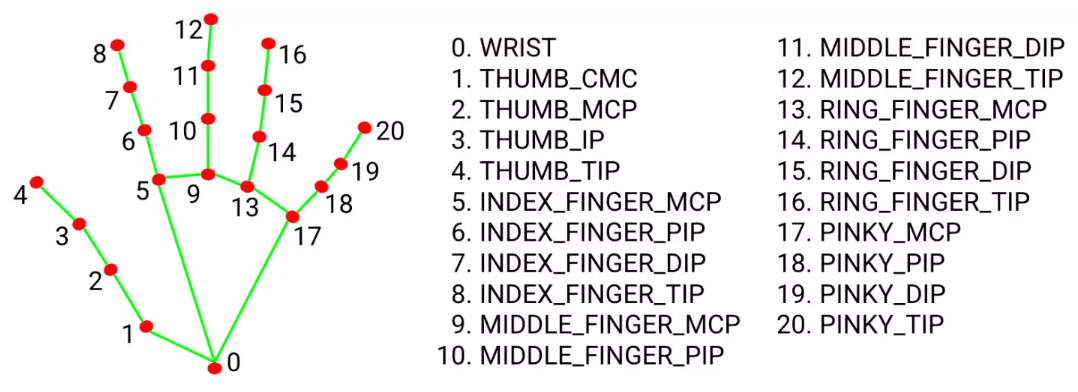

下方的程式碼延伸「[讀取並播放影片](https://steam.oxxostudio.tw/category/python/ai/opencv-read-video.html)」文章的範例，搭配 mediapipe 手掌偵測的方法，透過攝影鏡頭獲取影像後，即時顯示手掌的資訊。

In [ ]:
import cv2
import mediapipe as mp

# 設定方法
BaseOptions = mp.tasks.BaseOptions  # 基本選項，用於設置模型路徑等基本配置
HandLandmarker = mp.tasks.vision.HandLandmarker  # 手掌特徵點偵測器類
HandLandmarkerOptions = mp.tasks.vision.HandLandmarkerOptions  # 手掌特徵點偵測器選項類
VisionRunningMode = mp.tasks.vision.RunningMode  # 視覺運行模式類

# 偵測手掌設定
options = HandLandmarkerOptions(
    num_hands=2,  # 要偵測的手掌數量
    base_options=BaseOptions(model_asset_path=r'Model/16/hand_landmarker.task'),  # 模型路徑
    running_mode=VisionRunningMode.IMAGE  # 運行模式設為處理單張圖片
)

# 使用設定選項創建手掌特徵點偵測器
with HandLandmarker.create_from_options(options) as landmarker:
    cap = cv2.VideoCapture(0)  # 讀取攝影鏡頭，參數 0 表示使用預設攝影機
    if not cap.isOpened():
        print("Cannot open camera")  # 如果攝影機無法打開，印出錯誤訊息並退出
        exit()
    while True:
        ret, frame = cap.read()  # 讀取影片的每一幀
        if not ret:
            print("Cannot receive frame")  # 如果讀取錯誤，印出訊息並跳出迴圈
            break

        w = frame.shape[1]  # 畫面寬度
        h = frame.shape[0]  # 畫面高度

        # 將影像轉換為 Mediapipe 格式
        mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=frame)
        # 執行手掌偵測
        hand_landmarker_result = landmarker.detect(mp_image)
        
        # 印出手掌偵測結果
        print(hand_landmarker_result)
        
        # 顯示影像
        cv2.imshow('oxxostudio', frame)
        if cv2.waitKey(5) == ord('q'):  # 每 5 毫秒更新一次，直到按下 q 鍵結束
            break

    cap.release()  # 所有作業都完成後，釋放資源
    cv2.destroyAllWindows()  # 結束所有視窗

##### 即時繪製手掌骨架 
偵測到手掌後，參考「[Hand Landmarks Detection with MediaPipe Tasks](https://github.com/googlesamples/mediapipe/blob/main/examples/hand_landmarker/python/hand_landmarker.ipynb)」範例程式碼，\
加入標記繪圖的函式區塊，就可以在偵測到手掌時，即時繪製手掌的節點。

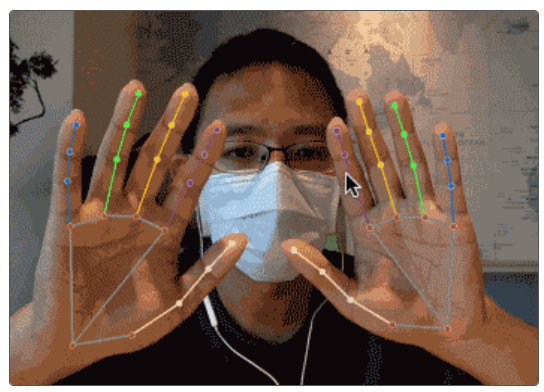

In [ ]:
import cv2
import numpy as np
import mediapipe as mp
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2

# 設定方法
BaseOptions = mp.tasks.BaseOptions  # 基本選項，用於設置模型路徑等基本配置
HandLandmarker = mp.tasks.vision.HandLandmarker  # 手掌特徵點偵測器類
HandLandmarkerOptions = mp.tasks.vision.HandLandmarkerOptions  # 手掌特徵點偵測器選項類
VisionRunningMode = mp.tasks.vision.RunningMode  # 視覺運行模式類

# 手掌偵測設定
options = HandLandmarkerOptions(
    num_hands=2,  # 要偵測的手掌數量
    base_options=BaseOptions(model_asset_path=r'Model/16/hand_landmarker.task'),  # 模型路徑
    running_mode=VisionRunningMode.IMAGE  # 運行模式設為處理單張圖片
)

# 標記文字設定
MARGIN = 10  # 標記文字的邊距，單位為像素
FONT_SIZE = 1  # 標記文字的字體大小
FONT_THICKNESS = 1  # 標記文字的字體粗細
HANDEDNESS_TEXT_COLOR = (88, 205, 54)  # 標記文字的顏色，這裡設為鮮綠色

# 繪製手掌骨架的函數
def draw_landmarks_on_image(rgb_image, detection_result):
    """
    在影像上繪製手掌特徵點和手勢（左手或右手）的函數。

    參數:
    rgb_image: numpy.ndarray - 要繪製特徵點的 RGB 影像。
    detection_result: mediapipe.framework.formats.landmark_pb2.NormalizedLandmarkList - 手掌偵測結果，包括特徵點和手勢。

    返回:
    annotated_image: numpy.ndarray - 繪製了手掌特徵點和手勢的影像。
    """
    hand_landmarks_list = detection_result.hand_landmarks  # 獲取手掌特徵點列表
    handedness_list = detection_result.handedness  # 獲取手勢（左手或右手）列表
    annotated_image = np.copy(rgb_image)  # 複製影像以進行標註

    # 遍歷偵測到的手掌以進行可視化
    for idx in range(len(hand_landmarks_list)):
        hand_landmarks = hand_landmarks_list[idx]  # 獲取當前手掌的特徵點
        handedness = handedness_list[idx]  # 獲取當前手掌的手勢（左手或右手）

        # 繪製手掌特徵點
        hand_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
        hand_landmarks_proto.landmark.extend([
            landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in hand_landmarks
        ])
        solutions.drawing_utils.draw_landmarks(
            annotated_image,  # 要在其上繪製特徵點的影像
            hand_landmarks_proto,  # 手掌特徵點列表
            solutions.hands.HAND_CONNECTIONS,  # 特徵點之間的連接關係，用於繪製手掌骨架
            solutions.drawing_styles.get_default_hand_landmarks_style(),  # 特徵點的繪製規格，使用預設的手掌特徵點樣式
            solutions.drawing_styles.get_default_hand_connections_style()  # 連接線的繪製規格，使用預設的手掌連接線樣式
        )

        # 獲取偵測到的手掌的邊界框左上角座標
        height, width, _ = annotated_image.shape  # 獲取影像的高度和寬度
        x_coordinates = [landmark.x for landmark in hand_landmarks]  # 獲取所有特徵點的 x 座標
        y_coordinates = [landmark.y for landmark in hand_landmarks]  # 獲取所有特徵點的 y 座標
        text_x = int(min(x_coordinates) * width)  # 計算標記文字的 x 座標
        text_y = int(min(y_coordinates) * height) - MARGIN  # 計算標記文字的 y 座標

        # 在影像上繪製手勢（左手或右手）
        cv2.putText(
            annotated_image,  # 要在其上繪製文字的影像
            f"{handedness[0].category_name}",  # 要繪製的文字內容（左手或右手）
            (text_x, text_y),  # 文字的座標
            cv2.FONT_HERSHEY_DUPLEX,  # 字體
            FONT_SIZE,  # 字體大小
            HANDEDNESS_TEXT_COLOR,  # 字體顏色
            FONT_THICKNESS,  # 字體粗細
            cv2.LINE_AA  # 抗鋸齒線條
        )

    return annotated_image  # 返回繪製了手掌特徵點和手勢的影像

# 使用設定選項創建手掌特徵點偵測器
with HandLandmarker.create_from_options(options) as landmarker:
    cap = cv2.VideoCapture(0)  # 讀取攝影鏡頭，參數 0 表示使用預設攝影機
    if not cap.isOpened():
        print("Cannot open camera")  # 如果攝影機無法打開，印出錯誤訊息並退出
        exit()
    while True:
        ret, frame = cap.read()  # 讀取影片的每一幀
        if not ret:
            print("Cannot receive frame")  # 如果讀取錯誤，印出訊息並跳出迴圈
            break

        w = frame.shape[1]  # 畫面寬度
        h = frame.shape[0]  # 畫面高度

        # 將影像轉換為 Mediapipe 格式
        mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=frame)
        # 執行手掌偵測
        hand_landmarker_result = landmarker.detect(mp_image)
        
        # 印出手勢（左手或右手）偵測結果
        print(hand_landmarker_result.handedness)

        # 繪製手掌特徵點和手勢
        annotated_image = draw_landmarks_on_image(frame, hand_landmarker_result)
        
        # 顯示標註後的影像
        cv2.imshow('oxxostudio', annotated_image)
        if cv2.waitKey(5) == ord('q'):  # 每 5 毫秒更新一次，直到按下 q 鍵結束
            break

    cap.release()  # 所有作業都完成後，釋放資源
    cv2.destroyAllWindows()  # 結束所有視窗